In [1]:
from fastai.tabular import *

# Data

In [44]:
df = pd.read_pickle('./data/ligamx/WLT2')

In [45]:
df['L_ES_LOC'] = True
df['V_ES_LOC'] = False

df.at[0, 'L_ES_LOC'] = False
df.at[0, 'V_ES_LOC'] = True

In [46]:
testing_df = df.iloc[range(143, 161)].copy()
valid_df = df.iloc[range(125, 143)].copy()

In [33]:
len(df)

4901

In [47]:
df.drop(df.index[range(161, 174)], inplace = True)
df.reset_index(drop=True, inplace=True)

In [48]:
def fix_idx(cdf):
    cdf.reset_index(drop=True, inplace=True)

In [49]:
df.drop(df.index[range(125, 161)], inplace = True)
fix_idx(df)

In [36]:
# df_extra_2019 = df[df.ANO == 2019].copy()

In [19]:
# df_extra_2019_apertura = df[df.ANO == 2019][df.TIPO == 'apertura'].copy()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [20]:
# df = pd.concat([df_extra_2019_apertura, df_extra_2019, df])
# df.reset_index(drop=True, inplace=True)

In [37]:
df_og = df.copy()

In [38]:
# DF for training
df = pd.concat([df_og, valid_df])
fix_idx(df)

In [39]:
# DF for testing
df_t = pd.concat([df_og, valid_df, testing_df])
fix_idx(df_t)

In [ ]:
def def_emb_sz_2(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    print(classes[n])
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(tabular.data.emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

In [ ]:
tabular.data.def_emb_sz = def_emb_sz_2

In [ ]:
df2 = df
deep_vars = ['RES']
#categorical values
cat_names = ['LOC', 'L_ES_LOC', 'VIS', 'V_ES_LOC', 'JRD', 'ANO', 'TIPO',]
#continious variables
cont_names = ['L_JJ', 'L_POS', 'V_POS',
       'L_R_JG_JJ', 'L_R_JE_JJ', 'L_R_JP_JJ', 'L_R_GF_JJ', 'L_R_GC_JJ',
       'L_R_DIF_JJ', 'L_R_PTS_JJ', 'V_JJ', 'V_R_JG_JJ', 'V_R_JE_JJ',
       'V_R_JP_JJ', 'V_R_GF_JJ', 'V_R_GC_JJ', 'V_R_DIF_JJ', 'V_R_PTS_JJ']
procs = [Categorify, Normalize]

data = (TabularList.from_df(df2, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_none()
   .label_from_df(cols=deep_vars)
   .databunch(bs=2))

data.get_emb_szs()

In [ ]:
data_lmx = df
data_separated = []
for i in range(2012, 2020):
    data_separated.append(pd.concat([data_lmx[data_lmx.ANO == i][data_lmx.TIPO == 'clausura'], data_lmx[data_lmx.ANO == i][data_lmx.TIPO == 'apertura']]))

sub_data = pd.concat([data_separated[6], data_separated[7]])
    
val_rng = range(155, 175)

for i, dataf in enumerate(data_separated):
    if i < 7: data_separated[i] = (pd.concat([dataf, data_lmx.iloc[val_rng]]))
    data_separated[i].reset_index(drop=True, inplace=True)
data_separated[0].tail()

# Regular

In [41]:
deep_vars = ['RES']
#categorical values
cat_names = ['LOC', 'VIS', 'JRD', 'ANO', 'TIPO']
#continious variables
cont_names = ['L_JJ', 'L_POS', 'V_POS',
       'L_R_JG_JJ', 'L_R_JE_JJ', 'L_R_JP_JJ', 'L_R_GF_JJ', 'L_R_GC_JJ',
       'L_R_DIF_JJ', 'L_R_PTS_JJ', 'V_JJ', 'V_R_JG_JJ', 'V_R_JE_JJ',
       'V_R_JP_JJ', 'V_R_GF_JJ', 'V_R_GC_JJ', 'V_R_DIF_JJ', 'V_R_PTS_JJ']
procs = [Categorify, Normalize]

data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(len(df)-18, len(df)))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))

learn = tabular_learner(data, layers=[500, 200, 100],  ps=[0.1, 0.1, 0.1], emb_drop=0.1, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 6.92E-03


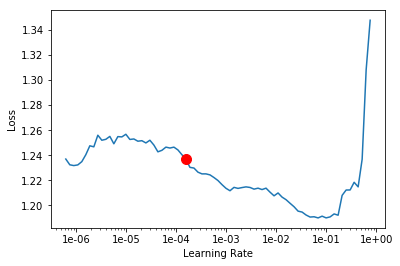

In [42]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [43]:
learn.fit_one_cycle(150, 1e-4, wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,1.222352,1.144405,0.333333,00:01
1,1.216577,1.149578,0.277778,00:01
2,1.200079,1.152589,0.222222,00:01
3,1.187416,1.162406,0.222222,00:01
4,1.175572,1.166316,0.222222,00:01
5,1.162981,1.168123,0.222222,00:01
6,1.161021,1.158970,0.222222,00:01
7,1.155203,1.160244,0.222222,00:01
8,1.149023,1.159206,0.277778,00:01
9,1.144975,1.150787,0.333333,00:01


In [ ]:
val_rng = range(len(df)-18, len(df))

x = 0
for i in val_rng:
    dta = df.iloc[i]
    pred = learn.predict(dta)
    pred = pred[2]
    preds = []
    for j in range(3):
        preds.append((pred[j].item(), j))
    preds.sort(reverse = True)
    #print(preds)
    if(preds[0][1] == dta.RES or preds[1][1] == dta.RES): x+=1
    
print(x, '/', len(val_rng))
x/len(val_rng)

In [ ]:
data = (TabularList.from_df(sub_data, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(list(range(len(sub_data)-20, len(sub_data))))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))

learn.data = data

In [ ]:
learn.lr_find()
learn.recorder.plot()

# Match Pred

## Model and learner

In [79]:
class MatchTabularModel(nn.Module):
    "Basic model for match tabular data."
    def __init__(self,
                 #Contestants parameters
                 emb_szs_cts:ListSizes=None, n_cont_cts:int=None, layers_cts:Collection[int]=None, ps_cts:Collection[float]=None, emb_drop_cts:float=0.,
                 #General Data parameters
                 emb_szs_grl:ListSizes=None, n_cont_grl:int=None, layers_grl:Collection[int]=None, ps_grl:Collection[float]=None, emb_drop_grl:float=0.,
                 #General Model parameters
                 use_bn:bool=True, bn_final:bool=False, out_sz:int=None, y_range:OptRange=None):
        super().__init__()
        
        """Simple Variable Setup -------------------------------------------------------------------------------------"""
        self.contestant_cat_n = len(emb_szs_cts)
        self.general_cat_n = len(emb_szs_grl)
        self.contestant_cont_n = n_cont_cts
        self.general_cont_n = n_cont_grl
        
        
        """Contestants Setup -------------------------------------------------------------------------------------"""
        # Dropout probabilities
        ps_cts = ifnone(ps_cts, [0]*len(layers_cts))
        ps_cts = listify(ps_cts, layers_cts)
        
        # Embeddings
        self.embeds_cts = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs_cts])
        self.emb_drop_cts = nn.Dropout(emb_drop_cts)
        n_emb_cts = sum(e.embedding_dim for e in self.embeds_cts)
        
        # Continious (non-embedding)
        self.bn_cont_cts = nn.BatchNorm1d(n_cont_cts)
        
        # Embeddings and Continious
        self.n_emb_cts, self.n_cont_cts = n_emb_cts, n_cont_cts
        sizes_cts = self.get_sizes(n_emb_cts, n_cont_cts, layers_cts)
        actns_cts = [nn.ReLU(inplace=True) for _ in range(len(sizes_cts)-1)]
        layers_cts = []
        for i,(n_in, n_out, dp, act) in enumerate(zip(sizes_cts[:-1], sizes_cts[1:], [0.]+ps_cts, actns_cts)):
            layers_cts += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        self.layers_cts = nn.Sequential(*layers_cts)
        print(layers_cts)

        """General Setup -------------------------------------------------------------------------------------"""
        # Dropout Probabilities
        ps_grl = ifnone(ps_grl, [0]*len(layers_grl))
        ps_grl = listify(ps_grl, layers_grl)
        
        # Embeddings
        self.embeds_grl = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs_grl])
        self.emb_drop_grl = nn.Dropout(emb_drop_grl)
        n_emb_grl = sum(e.embedding_dim for e in self.embeds_grl)
        
        # Continious (non-embedding)
        n_cont_grl += sizes_cts[-1]*2 # adding output from contestants subnet to the size of the continious input
        self.bn_cont_grl = nn.BatchNorm1d(n_cont_grl)
        
        # Embeddings and Continitous
        self.n_emb_grl, self.n_cont_grl = n_emb_grl, n_cont_grl
        sizes_grl = self.get_sizes(n_emb_grl, n_cont_grl, layers_grl, out_sz)
        actns_grl = [nn.ReLU(inplace=True) for _ in range(len(sizes_grl)-2)] + [None]
        layers_grl = []
        for i,(n_in, n_out, dp, act) in enumerate(zip(sizes_grl[:-1], sizes_grl[1:], [0.]+ps_grl, actns_grl)):
            layers_grl += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        
        if bn_final: layers_grl.append(nn.BatchNorm1d(sizes_grl[-1]))
        self.layers_grl = nn.Sequential(*layers_grl)
    

        """General Model Setup -------------------------------------------------------------------------------------"""
        self.y_range = y_range

    def get_sizes(self, n_emb, n_cont, layers, out_sz = None):
        res = [n_emb + n_cont] + layers
        return  res + [out_sz] if out_sz is not None else res

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        contestant_cat = self.contestant_cat_n
        general_cat = self.general_cat_n
        contestant_cont = self.contestant_cont_n
        general_cont = self.general_cont_n

        with torch.no_grad():
            cat_a = x_cat[:, :contestant_cat].clone()
            cat_b = x_cat[:, contestant_cat:contestant_cat*2].clone()
            cat_grl = x_cat[:, contestant_cat*2:].clone()
            
            cont_a = x_cont[:, :contestant_cont].clone()
            cont_b = x_cont[:, contestant_cont:contestant_cont*2].clone()
            cont_grl = x_cont[:, contestant_cont*2:].clone()
        
        # Forward of Contestant Layers:
        if self.n_emb_cts != 0:
            a = [e(cat_a[:,i]) for i,e in enumerate(self.embeds_cts)]
            b = [e(cat_b[:,i]) for i,e in enumerate(self.embeds_cts)]
            
            a = torch.cat(a, 1)
            b = torch.cat(b, 1)
            
            # Not very sure about this step, check here and in layers.
            # TODO: implement later: https://discuss.pytorch.org/t/how-to-fix-the-dropout-mask-for-different-batch/7119/3
            a = self.emb_drop_cts(a)
            b = self.emb_drop_cts(b)
        
        if self.n_cont_cts != 0:
            # not sure about this step, check here and in layers
            # TODO: check best practice for the batchnorm (use the same normalization for both or not)
            cont_a = self.bn_cont_cts(cont_a)
            cont_b = self.bn_cont_cts(cont_b)
            
            a = torch.cat([a, cont_a], 1) if self.n_emb_cts != 0 else cont_a
            b = torch.cat([b, cont_b], 1) if self.n_emb_cts != 0 else cont_b
            
        if self.n_emb_cts > 0 or self.n_cont_cts > 0:
            a = self.layers_cts(a)
            b = self.layers_cts(b)
            # SUM
            x = torch.cat([a, b], 1)
        
        if self.n_cont_grl != 0:
            x = torch.cat([x, cont_grl], 1) if self.n_emb_cts > 0 or self.n_cont_cts else cont_grl
            x = self.bn_cont_grl(x)
        if self.n_emb_grl != 0:
            x_cat = [e(cat_grl[:,i]) for i,e in enumerate(self.embeds_grl)]
            x_cat = torch.cat(x_cat, 1)
            x_cat = self.emb_drop_grl(x_cat)
            x = torch.cat([x, x_cat], 1)
            
        x = self.layers_grl(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [14]:
def match_tabular_learner(
    #Contestants parameters
    layers_cts:Collection[int]=None, emb_szs_cts:Dict[str,int]=None, continious_len_cts:[int]=None, ps_cts:Collection[float]=None, emb_drop_cts:float=0.,
    
    #General parameters
    layers_grl:Collection[int]=None, emb_szs_grl:Dict[str,int]=None, continious_len_grl:[int]=None, ps_grl:Collection[float]=None, emb_drop_grl:float=0.,
    
    #General
    data:DataBunch=None, metrics=None, y_range:OptRange=None, use_bn:bool=True, **learn_kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    
    model = MatchTabularModel(
        #Contestants parameters
        emb_szs_cts, continious_len_cts, layers_cts, ps_cts, emb_drop_cts,
        
        #General parameters
        emb_szs_grl, continious_len_grl, layers_grl, ps_grl, emb_drop_grl,
        
        #General
        use_bn, out_sz = data.c, y_range=y_range)
    return Learner(data, model, metrics=metrics, **learn_kwargs)

## Use of Model

In [68]:
deep_vars = ['RES']
#categorical values
cat_names = ['LOC',
             'VIS',
             'JRD', 'ANO', 'TIPO']
#continious variables
cont_names = ['L_JJ', 'L_POS', 'L_R_JG_JJ', 'L_R_JE_JJ', 'L_R_JP_JJ', 'L_R_GF_JJ', 'L_R_GC_JJ', 'L_R_DIF_JJ', 'L_R_PTS_JJ',
              'V_JJ', 'V_POS', 'V_R_JG_JJ', 'V_R_JE_JJ', 'V_R_JP_JJ', 'V_R_GF_JJ', 'V_R_GC_JJ', 'V_R_DIF_JJ', 'V_R_PTS_JJ']
procs = [Categorify, Normalize]

In [ ]:
len(df)

In [ ]:
df.iloc[range(154, 174)]

In [76]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(len(df)-18, len(df)))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([500], [(29, 11)], 9, [0.1], 0.1,
                              [200], [(21, 9), (17, 8), (3, 3)], 0, [0.1], 0.1,
                               data, metrics=accuracy)

[Linear(in_features=20, out_features=500, bias=True), ReLU(inplace=True)]


In [22]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (4865 items)
x: TabularList
LOC puebla; VIS tijuana; JRD 1.0; ANO 2019; TIPO apertura; L_JJ -1.6216; L_POS -1.6440; L_R_JG_JJ -1.4181; L_R_JE_JJ -1.2420; L_R_JP_JJ -1.4345; L_R_GF_JJ -1.9524; L_R_GC_JJ -1.9671; L_R_DIF_JJ 0.0493; L_R_PTS_JJ -1.8627; V_JJ -1.6215; V_POS -1.5672; V_R_JG_JJ -1.4556; V_R_JE_JJ -1.2469; V_R_JP_JJ -1.3898; V_R_GF_JJ -1.9557; V_R_GC_JJ -2.0158; V_R_DIF_JJ -0.0662; V_R_PTS_JJ -1.9094; ,LOC atlas; VIS fc juarez; JRD 1.0; ANO 2019; TIPO apertura; L_JJ -1.6216; L_POS -1.6440; L_R_JG_JJ -1.4181; L_R_JE_JJ -1.2420; L_R_JP_JJ -1.4345; L_R_GF_JJ -1.9524; L_R_GC_JJ -1.9671; L_R_DIF_JJ 0.0493; L_R_PTS_JJ -1.8627; V_JJ -1.6215; V_POS -1.5672; V_R_JG_JJ -1.4556; V_R_JE_JJ -1.2469; V_R_JP_JJ -1.3898; V_R_GF_JJ -1.9557; V_R_GC_JJ -2.0158; V_R_DIF_JJ -0.0662; V_R_PTS_JJ -1.9094; ,LOC atletico de san luis; VIS unam; JRD 1.0; ANO 2019; TIPO apertura; L_JJ -1.6216; L_POS -1.6440; L_R_JG_JJ -1.4181; L_R_JE_JJ -1.2420; L_R_JP_JJ -

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


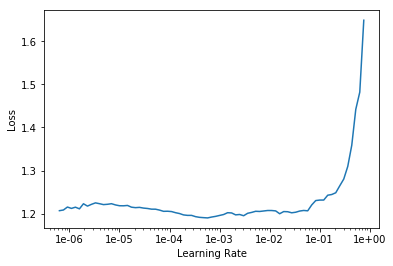

In [77]:
learn.lr_find()
learn.recorder.plot()

In [78]:
opt = learn.fit_one_cycle(150, 1e-4, wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,1.180370,1.085488,0.388889,00:02
1,1.153889,1.059616,0.444444,00:03
2,1.140371,1.051938,0.388889,00:02
3,1.132210,1.067800,0.388889,00:02
4,1.123822,1.043790,0.500000,00:03
5,1.112197,1.064460,0.500000,00:02
6,1.116818,1.054445,0.500000,00:02
7,1.114223,1.050576,0.555556,00:02
8,1.111087,1.037667,0.500000,00:02
9,1.102585,1.036324,0.555556,00:03


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle??

In [ ]:
# learn.save('o2')
# learn.load('o2')

In [ ]:
learn.fit_one_cycle(10, 6e-7, wd=0.3)

In [ ]:
#sub_data = pd.concat([data_separated[6], data_separated[7]])

val_rng = range(len(sub_data)-20, len(sub_data))

data = (TabularList.from_df(sub_data, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(val_rng)
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn.data = data

In [ ]:
val_rng = range(152, 167)
df.iloc[val_rng]

In [ ]:
df.iloc[range(154, 174)]

In [ ]:
sub_data.reset_index(drop=True, inplace=True)
sub_data.tail()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(10, 1e-20, wd=0.5)

In [ ]:
# learn.save('MatchPred1')

In [ ]:
len(df)

In [ ]:
len(data_lmx)

In [ ]:
val_rng = range(152, 161)

x = 0
for i in val_rng:
    dta = df.iloc[i]
    pred = learn.predict(dta)
    pred = pred[2]
    preds = []
    for j in range(3):
        preds.append((pred[j].item(), j))
    preds.sort(reverse = True)
    #print(preds)
    if(preds[0][1] == dta.RES or preds[1][1] == dta.RES): x+=1
    
print(x, '/', len(val_rng))
x/len(val_rng)

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(154, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn.data = data

In [ ]:
learn.fit_one_cycle(10, 1e-1000, wd=0.3)

## Iterative training

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_none()
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))

learn = match_tabular_learner([200, 100, 50], [(27, 50), (3, 5)], 9, None, 0.,
                               [100, 50], [(21, 9), (9, 5), (3, 3)], 0, None, 0.,
                               data, metrics=accuracy)

for dta in data_separated:
    data = (TabularList.from_df(dta, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(len(dta)-20, len(dta)))
   .label_from_df(cols=deep_vars)
   .databunch(bs=45))
    learn.data = data
    learn.fit(7, 1e-3, wd=0.4)
    

## Several tryouts

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(134, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([350, 150], [(29, 15), (3, 3)], 9, [0.3, 0.3], 0.3,
                               [100], [(21, 9), (17, 8), (3, 3)], 0, [0.3], 0.3,
                               data, metrics=accuracy)
learn.fit_one_cycle(200, 1e-4, wd=0.3)

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(154, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([200, 100], [(29, 15), (3, 3)], 9, [0.3, 0.3], 0.3,
                               [70], [(21, 9), (17, 8), (3, 3)], 0, [0.3], 0.3,
                               data, metrics=accuracy)
learn.fit_one_cycle(200, 1e-4, wd=0.3)

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(154, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([500], [(29, 15), (3, 3)], 9, [0.2], 0.2,
                               [100], [(21, 9), (17, 8), (3, 3)], 0, [0.2], 0.2,
                               data, metrics=accuracy)
learn.fit_one_cycle(200, 1e-4, wd=0.3)

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(154, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([550], [(29, 15), (3, 3)], 9, [0.2], 0.2,
                               [70], [(21, 9), (17, 8), (3, 3)], 0, [0.2], 0.2,
                               data, metrics=accuracy)
learn.fit_one_cycle(200, 1e-4, wd=0.3)

In [ ]:
data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
   .split_by_idx(range(134, 174))
   .label_from_df(cols=deep_vars)
   .databunch(bs=64))
learn = match_tabular_learner([300], [(29, 15), (3, 3)], 9, [0.2], 0.2,
                               [300], [(21, 9), (17, 8), (3, 3)], 0, [0.2], 0.2,
                               data, metrics=accuracy)
learn.fit_one_cycle(200, 1e-4, wd=0.3)

## Trying regular

In [ ]:
def tryRegular():
    deep_vars = ['RES']
    #categorical values
    cat_names = ['LOC', 'VIS', 'JRD', 'ANO', 'TIPO']
    #continious variables
    cont_names = ['L_JJ', 'L_POS', 'V_POS',
           'L_R_JG_JJ', 'L_R_JE_JJ', 'L_R_JP_JJ', 'L_R_GF_JJ', 'L_R_GC_JJ',
           'L_R_DIF_JJ', 'L_R_PTS_JJ', 'V_JJ', 'V_R_JG_JJ', 'V_R_JE_JJ',
           'V_R_JP_JJ', 'V_R_GF_JJ', 'V_R_GC_JJ', 'V_R_DIF_JJ', 'V_R_PTS_JJ']
    procs = [Categorify, Normalize]

    data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
       .split_by_idx(list(range(152, 161)))
       .label_from_df(cols=deep_vars)
       .databunch(bs=64))

    learn = tabular_learner(data, layers=[500, 200, 100],  ps=[0.1, 0.1, 0.1], emb_drop=0.1, metrics=accuracy)
    learn.fit_one_cycle(150, 1e-4, wd=0.3)

In [ ]:
for i in range(10):
    tryRegular()

In [ ]:
tr = [0.801, 0.815, 0.811, 0.816, 0.791, 0.787, 0.797, 0.800, 0.790, 0.790]
vl = [0.788, 0.757, 0.756, 0.776, 0.800, 0.839, 0.681, 0.800, 0.681, 0.71]
tr = tensor(tr)
vl = tensor(vl)

print(tr.mean(), tr.std())
print(vl.mean(), vl.std())

## Try MatchPred

In [ ]:
def try_match_pred():
    deep_vars = ['RES']
    #categorical values
    cat_names = ['LOC',
                 'VIS',
                 'JRD', 'ANO', 'TIPO']
    #continious variables
    cont_names = ['L_JJ', 'L_POS', 'L_R_JG_JJ', 'L_R_JE_JJ', 'L_R_JP_JJ', 'L_R_GF_JJ', 'L_R_GC_JJ', 'L_R_DIF_JJ', 'L_R_PTS_JJ',
                  'V_JJ', 'V_POS', 'V_R_JG_JJ', 'V_R_JE_JJ', 'V_R_JP_JJ', 'V_R_GF_JJ', 'V_R_GC_JJ', 'V_R_DIF_JJ', 'V_R_PTS_JJ']
    procs = [Categorify, Normalize]

    data = (TabularList.from_df(df, path="./data/ligamx", cat_names=cat_names, cont_names=cont_names, procs=procs)
       .split_by_idx(range(152, 161))
       .label_from_df(cols=deep_vars)
       .databunch(bs=64))
    learn = match_tabular_learner([90, 20], [(29, 15)], 9, [0.1, 0.1], 0.1,
                                   [500, 200, 100], [(21, 9), (17, 8), (3, 3)], 0, [0.1, 0.1, 0.1], 0.1,
                                   data, metrics=accuracy)

    learn.fit_one_cycle(200, 1e-4, wd=0.3)

In [ ]:
for i in range(10):
    try_match_pred()